# Import and setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import few

from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import SchwarzEccFlux, KerrEccEqFlux
# from few.amplitude.romannet import RomanAmplitude
from few.amplitude.ampinterp2d import AmpInterpKerrEccEq
from few.summation.interpolatedmodesum import InterpolatedModeSum


from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few import get_file_manager

from few.waveform import (
    FastKerrEccentricEquatorialFlux,
    FastSchwarzschildEccentricFlux, 
    SlowSchwarzschildEccentricFlux, 
    Pn5AAKWaveform,
    GenerateEMRIWaveform
)

from few.utils.geodesic import get_fundamental_frequencies

import GWfuncs
import gc
import pickle
import os
import cupy as cp
import multiprocessing as mp
from multiprocessing import Queue, Process
from functools import partial
from SNR_tutorial_utils import LISA_Noise
from lisatools.sensitivity import *

from few.utils.constants import YRSID_SI, Gpc, MRSUN_SI



# import pandas as pd
# tune few configuration
cfg_set = few.get_config_setter(reset=True)
cfg_set.set_log_level("info");

In [2]:
# Parameters
m1 = 1e6 #M
m2 = 1e1 #mu
a = 0.5
p0 = 9.5
e0 = 0.2
theta = np.pi / 3.0 
phi = np.pi / 4.0  
dt = 10.0
T = 1
xI0 = 1.0 
#in the paper xI0 = 0.866, but that would be non-equatorial case

use_gpu = True 
traj = EMRIInspiral(func=KerrEccEqFlux, force_backend="cuda12x", use_gpu=use_gpu, npoints=50)
amp = AmpInterpKerrEccEq(force_backend="cuda12x") # default lmax=10, nmax=55
interpolate_mode_sum = InterpolatedModeSum(force_backend="cuda12x")
ylm_gen = GetYlms(include_minus_m=False, force_backend="cuda12x")

# Generate waveform

In [162]:
delta_T = T*YRSID_SI/500 # change amount of points here
delta_T

63116.29952709119

In [163]:
%%time 
# Calc trajectory
(t, p, e, x, Phi_phi, Phi_theta, Phi_r) = traj(m1, m2, a, p0, e0, xI0, T=T, dt=delta_T, DENSE_STEPPING=True)#upsampling=True, fix_t=True

# Get amplitudes along trajectory
teuk_modes = amp(a, p, e, x)

# Get Ylms
ylms = ylm_gen(amp.unique_l, amp.unique_m, theta, phi).copy()[amp.inverse_lm]

cp.cuda.Stream.null.synchronize()

CPU times: user 155 ms, sys: 954 μs, total: 155 ms
Wall time: 155 ms


In [164]:
len(t)

500

In [165]:
np.diff(t)

array([63116.29952709, 63116.29952709, 63116.29952709, 63116.29952709,
       63116.29952709, 63116.29952709, 63116.29952709, 63116.29952709,
       63116.29952709, 63116.29952709, 63116.29952709, 63116.29952709,
       63116.29952709, 63116.29952709, 63116.29952709, 63116.29952709,
       63116.29952709, 63116.29952709, 63116.29952709, 63116.29952709,
       63116.29952709, 63116.29952709, 63116.29952709, 63116.29952709,
       63116.29952709, 63116.29952709, 63116.29952709, 63116.29952709,
       63116.29952709, 63116.29952709, 63116.29952709, 63116.29952709,
       63116.29952709, 63116.29952709, 63116.29952709, 63116.29952709,
       63116.29952709, 63116.29952709, 63116.29952709, 63116.29952709,
       63116.29952709, 63116.29952709, 63116.29952709, 63116.29952709,
       63116.29952709, 63116.29952709, 63116.29952709, 63116.29952709,
       63116.29952709, 63116.29952709, 63116.29952709, 63116.29952709,
       63116.29952709, 63116.29952709, 63116.29952709, 63116.29952709,
      

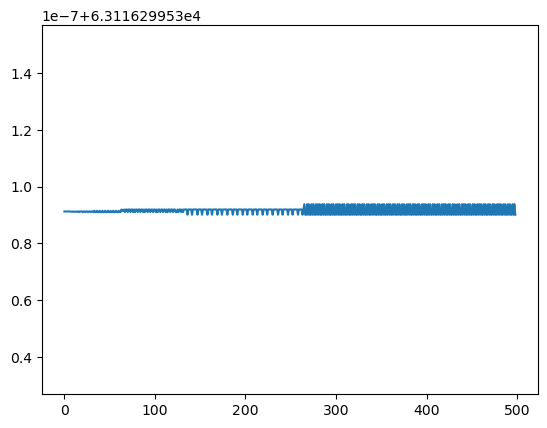

In [166]:
plt.plot(np.diff(t))

In [167]:
%%time

t_gpu = cp.asarray(t)

# need to prepare arrays for sum with all modes due to +/- m setup
ls = amp.l_arr[: teuk_modes.shape[1]]
ms = amp.m_arr[: teuk_modes.shape[1]]
ns = amp.n_arr[: teuk_modes.shape[1]]

keep_modes = np.arange(teuk_modes.shape[1])
temp2 = keep_modes * (keep_modes < amp.num_m0) + (keep_modes + amp.num_m_1_up) * (
    keep_modes >= amp.num_m0
) # amp.num_m0 gives number of modes with m == 0, amp.num_m_1_up gives number of modes with m > 0

ylmkeep = np.concatenate([keep_modes, temp2])
ylms_in = ylms[ylmkeep]
teuk_modes_in = teuk_modes

cp.cuda.Stream.null.synchronize()

CPU times: user 963 μs, sys: 0 ns, total: 963 μs
Wall time: 803 μs


In [ ]:
%%time

# perform summation
waveform1 = interpolate_mode_sum(
    t_gpu,
    teuk_modes_in,
    ylms_in,
    traj.integrator_spline_t,
    traj.integrator_spline_phase_coeff[:, [0, 2]],
    ls,
    ms,
    ns,
    dt=dt,
    T=T,
)

cp.cuda.Stream.null.synchronize()

In [161]:
waveform1

array([nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
      shape=(3155815,))

In [14]:
N = int(len(waveform1)) 
gwf = GWfuncs.GravWaveAnalysis(N=N,dt=dt)
# Calculate distance dimensionless
dist = 1.0 #Gpc
factor = gwf.dist_factor(dist, m2)
waveform1_scaled = waveform1.get()/factor

In [111]:
p

array([9.5       , 9.48019521, 9.46025158, 9.44016679, 9.41993846,
       9.39956416, 9.37904137, 9.35836753, 9.33753997, 9.31655598,
       9.29541275, 9.2741074 , 9.25263696, 9.23099839, 9.20918853,
       9.18720414, 9.16504189, 9.14269834, 9.12016994, 9.09745302,
       9.07454381, 9.0514384 , 9.02813278, 9.00462279, 8.98090411,
       8.95697231, 8.93282278, 8.90845077, 8.88385135, 8.85901942,
       8.83394967, 8.80863665, 8.78307464, 8.75725776, 8.73117986,
       8.70483459, 8.67821532, 8.65131516, 8.62412695, 8.59664322,
       8.56885621, 8.54075779, 8.51233951, 8.48359254, 8.45450764,
       8.42507517, 8.39528501, 8.36512661, 8.33458886, 8.30366014])

In [16]:
waveform1_scaled

array([nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
      shape=(3155815,))

In [15]:
hfull_f = gwf.freq_wave(waveform1_scaled)

SNR_ref = gwf.SNR(hfull_f)
print("SNR:", SNR_ref)
print("SNR squared:", SNR_ref**2)

SNR: nan
SNR squared: nan


In [ ]:
# Convert T to standard units
T_sd = 1.0 * YRSID_SI  # 1 sidereal year in seconds (~31,558,150 seconds)
print("Observation time in seconds:", T_sd)

In [ ]:
N_traj = teuk_modes.shape[0]  # number of trajectory points
print("Number of trajectory points:", N_traj)
delta_T = T_sd / N_traj  # time step in seconds
print("Time step in seconds", delta_T)

In [ ]:
# Get mode labels
mode_labels = [f"({l},{m},{n})" for l,m,n in zip(amp.l_arr, amp.m_arr, amp.n_arr)]

# Generate mode frequencies 

Using *get_fundamental_frequencies* instead

In [ ]:
OmegaPhi, OmegaTheta, OmegaR = get_fundamental_frequencies(a, p, e, x)

In [ ]:
OmegaPhi

In [ ]:
gw_frequencies_per_mode = []
mode_frequencies = {}

for idx in range(len(mode_labels)):
    l = amp.l_arr[idx]
    m = amp.m_arr[idx] 
    n = amp.n_arr[idx]
    
    # Calculate GW frequencies
    # k = 0 for equatorial case
    f_gw = m * OmegaPhi + n * OmegaR
    
    gw_frequencies_per_mode.append(f_gw)

In [ ]:
gw_phase_per_mode = []
for idx in range(len(mode_labels)):
    l = amp.l_arr[idx]
    m = amp.m_arr[idx] 
    n = amp.n_arr[idx]
    
    # Calculate GW phases per mode
    phi_mode = m * Phi_phi + n * Phi_r
    
    gw_phase_per_mode.append(phi_mode)

# Calculate inner product

In [ ]:
idx_i = 1165 # 220
idx_j = 1166 # 221
mode_labels[idx_i], mode_labels[idx_j]

In [ ]:
# Get complex amplitudes for the two modes
A0 = teuk_modes[:, idx_i]
A1 = teuk_modes[:, idx_j]
print("A_0:", A0)
print("A_1:", A1)

In [ ]:
# Get sensitivity for the two modes
Sn0 = get_sensitivity(gw_frequencies_per_mode[idx_i], sens_fn=LISASens, return_type="PSD")
Sn1 = get_sensitivity(gw_frequencies_per_mode[idx_j], sens_fn=LISASens, return_type="PSD")

In [ ]:
barA0 = A0 / np.sqrt(Sn0)
barA0 

In [ ]:
barA1 = A1 / np.sqrt(Sn1)
barA1

In [ ]:
phase01 = np.abs(gw_phase_per_mode[idx_i] - gw_phase_per_mode[idx_j]) < 1.0 
phase01

## Cross-term inner product of (2,2,0) & (2,2,1)

In [ ]:
crossprod01 = np.conj(barA0[phase01]) * barA1[phase01]
crossprod01

In [ ]:
inner_contrib_01 = np.sum(crossprod01) * delta_T * 1/(factor**2)
np.real(inner_contrib_01)

## Self-term inner product of (2,2,0)

In [ ]:
selfprod00 = np.conj(barA0)*barA0 #barA0**2
selfprod00

In [ ]:
inner_contrib_00 = np.sum(np.real(selfprod00)) * delta_T * 1/(factor**2)
inner_contrib_00

In [ ]:
inner_contrib_11 = np.sum(np.real(np.conj(barA1)*barA1)) * delta_T * 1/(factor**2)
inner_contrib_11

In [ ]:
np.abs(inner_contrib_01 / np.sqrt(inner_contrib_00 * inner_contrib_11) )

## Discrepancy of self-term between squared and conj*original array?

In [ ]:
np.real(np.sum(barA0**2) * delta_T * 1/(factor**2))

In [ ]:
np.real(np.sum(np.conj(barA1)*barA1) * delta_T * 1/(factor**2))

In [ ]:
np.real(np.sum(barA1**2) * delta_T * 1/(factor**2))

# Reference values

In [ ]:
indices = [1165, 1166]

In [ ]:
waveform_per_mode = []
for idx in indices:
    l = amp.l_arr[idx]
    m = amp.m_arr[idx]
    n = amp.n_arr[idx]
    print('Mode: ', mode_labels[idx])

    if m >= 0:
        # For m >= 0, directly use the mode
        teuk_modes_single = teuk_modes[:, [idx]]
        ylms_single = ylms[[idx]]
        m_arr = amp.m_arr[[idx]]
    else:
        # Finding corresponding m>0 mode instead of mapping
        print('NEGATIVE M MODE')
        pos_m_mask = (amp.l_arr == l) & (amp.m_arr == -m) & (amp.n_arr == n) 
        print(amp.l_arr[pos_m_mask], amp.m_arr[pos_m_mask], amp.n_arr[pos_m_mask])
        pos_m_idx = np.where(pos_m_mask)[0]
        print(pos_m_idx)
        
        teuk_modes_single = (-1)**l * np.conj(teuk_modes[:, [pos_m_idx]])
        print(teuk_modes_single)
        # ylms_single = (-1)**(-m) * np.conj(ylms[[pos_m_idx]])
        ylms_single = ylms[[idx]]
        print(ylms_single)
        m_arr = np.abs(amp.m_arr[[idx]])  # To pass positive m 

    waveform = interpolate_mode_sum(
        t,
        teuk_modes_single,
        ylms_single,
        traj.integrator_spline_t,
        traj.integrator_spline_phase_coeff[:, [0, 2]],
        amp.l_arr[[idx]], 
        m_arr,  
        amp.n_arr[[idx]], 
        dt=dt,
        T=T
    )
    waveform_per_mode.append(waveform/factor)

In [ ]:
# Convert each waveform to frequency domain
hf_per_mode = [gwf.freq_wave(waveform) for waveform in waveform_per_mode]

In [ ]:
gwf.inner(hf_per_mode[0], hf_per_mode[1])

In [ ]:
gwf.inner(hf_per_mode[0], hf_per_mode[0])

In [ ]:
gwf.inner(hf_per_mode[1], hf_per_mode[1])